# Machine Learning 2: Group 3 Project
The goal is to predict a patient's smoking status given information about various other health indicators (smoking column, binary classification).

## Libraries and Importing the Dataset

In [1]:
# The usual suspects
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Import stuff for EDA and Feature Engineerign
from sklearn.preprocessing import OneHotEncoder

# These are the classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#Tools and Metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay
#import optuna
from sklearn.model_selection import cross_val_score

# This function displays the splits of the tree
from sklearn.tree import plot_tree

# This is the function that helps plot feature importance
from xgboost import plot_importance

# This module lets us save our models once we fit them.
import pickle

#This is for visualization
#from dtreeviz.trees import *

import warnings
warnings.filterwarnings('ignore')


In [2]:
#Notebook setup
pd.set_option('display.max_columns', None)

In [5]:
# We need to download the data from Kaggle and upload it here
data = pd.read_csv("content/train.csv")

In [6]:
# Sample the data
data = data.sample(frac=0.5).reset_index(drop=True) # Sample the dataset

In [7]:
# Check that the data is ok
data.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,81073,40,160,70,84.0,1.2,1.2,1,1,113,77,98,231,111,60,148,14.3,1,0.8,22,19,27,1,0
1,67364,40,165,60,77.0,1.0,0.9,1,1,134,71,96,197,197,41,116,15.9,1,1.1,31,51,45,0,1
2,105694,55,165,65,78.0,0.8,0.6,1,1,138,88,99,220,99,66,133,15.7,1,1.1,25,23,18,1,1
3,76550,60,145,55,87.0,0.8,0.1,1,1,139,93,102,214,88,45,150,12.6,1,1.1,20,18,35,1,0
4,128578,40,180,70,87.0,1.2,1.0,1,1,120,80,96,196,195,40,117,15.5,1,1.0,18,15,24,0,0


## Exploratory Data Analysis

First check for datatypes, null values, and duplicates.

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79628 entries, 0 to 79627
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   79628 non-null  int64  
 1   age                  79628 non-null  int64  
 2   height(cm)           79628 non-null  int64  
 3   weight(kg)           79628 non-null  int64  
 4   waist(cm)            79628 non-null  float64
 5   eyesight(left)       79628 non-null  float64
 6   eyesight(right)      79628 non-null  float64
 7   hearing(left)        79628 non-null  int64  
 8   hearing(right)       79628 non-null  int64  
 9   systolic             79628 non-null  int64  
 10  relaxation           79628 non-null  int64  
 11  fasting blood sugar  79628 non-null  int64  
 12  Cholesterol          79628 non-null  int64  
 13  triglyceride         79628 non-null  int64  
 14  HDL                  79628 non-null  int64  
 15  LDL                  79628 non-null 

There are no null values so we can skip huntind the NAs

In [9]:
#Check for null values
data.isnull().sum()

id                     0
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64

Same for duplicates

In [10]:
# Identify duplicates
duplicates = data[data.duplicated()]
print(f"Number of duplicates found: {len(duplicates)}")

Number of duplicates found: 0


###Class Balance

The `smoking` feature is balanced

In [13]:
# Check class balance
data['smoking'].value_counts()

smoking
0    44708
1    34920
Name: count, dtype: int64

###Feature Distribution

Plot all the features

###Feature Correlation

Plot the correlation

In [ ]:
import seaborn as sns

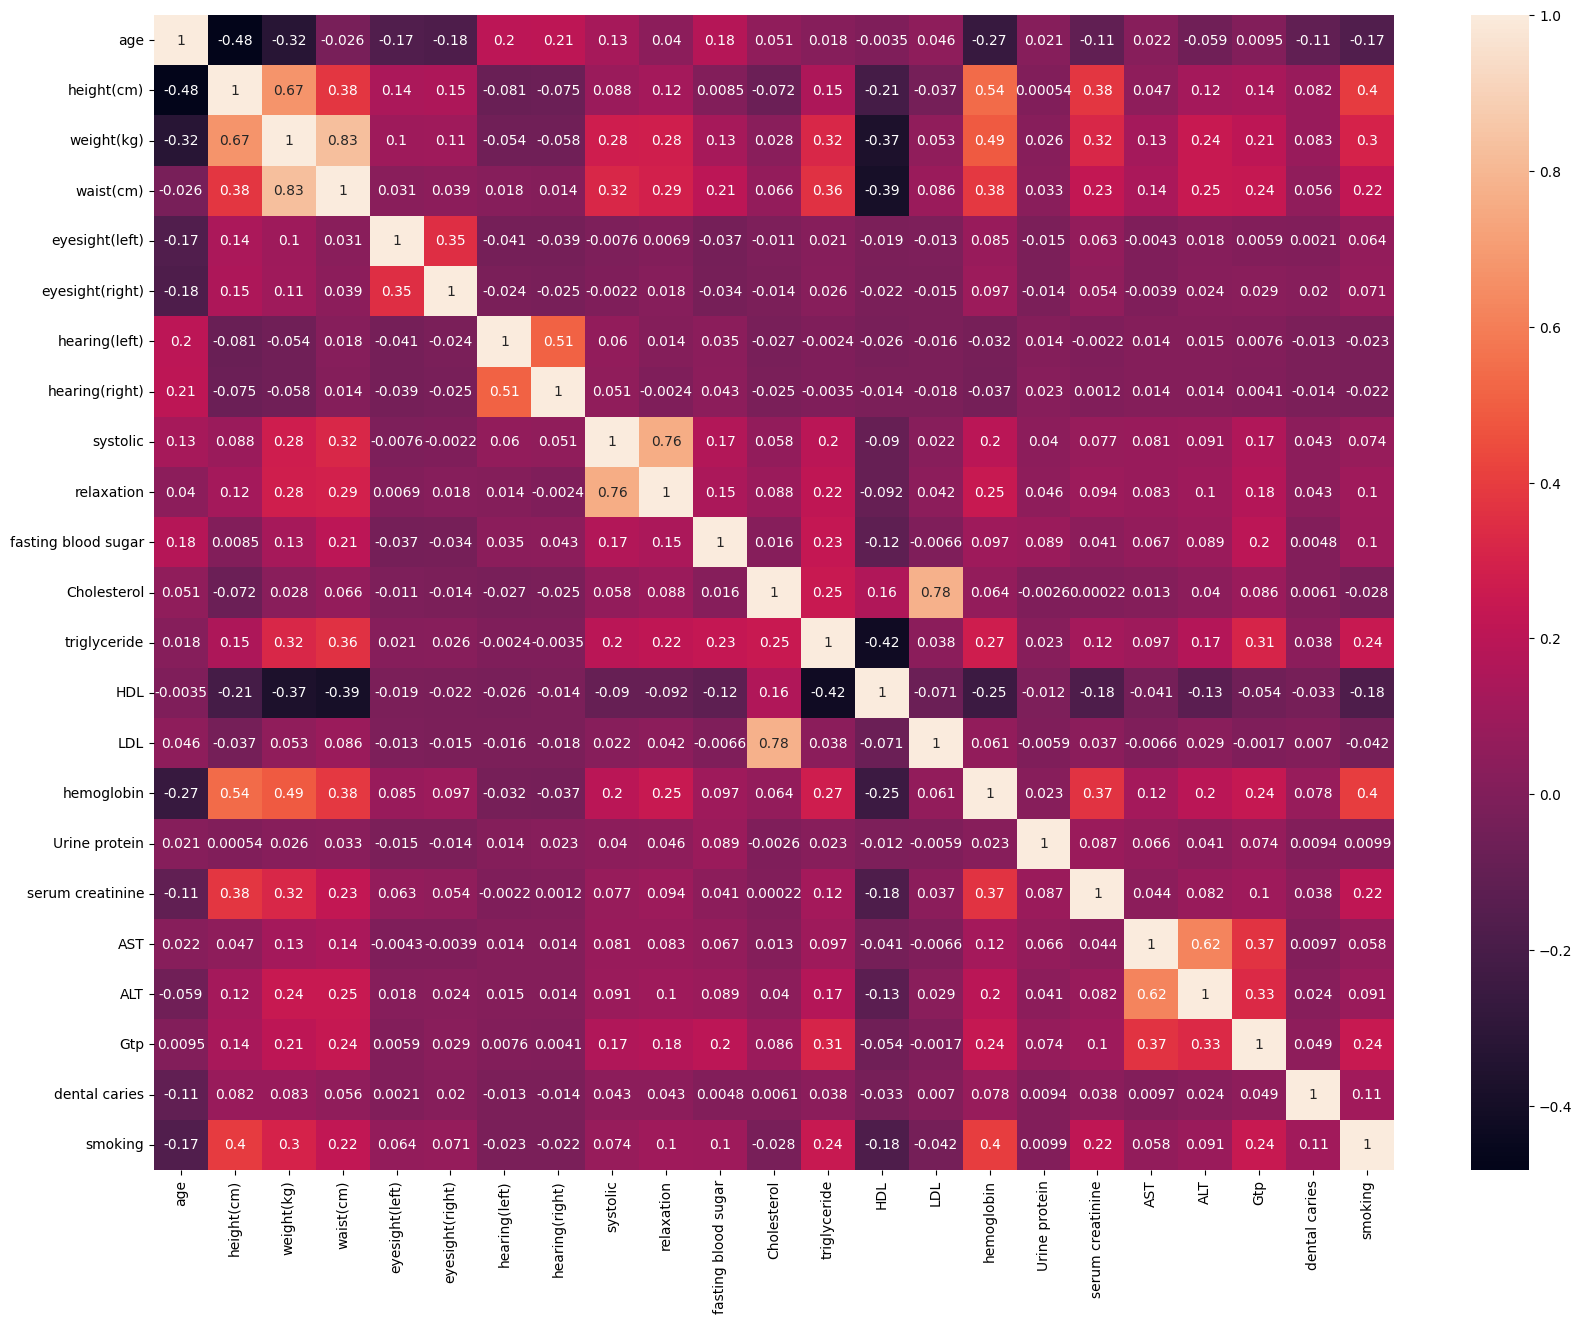

In [ ]:
plt.figure(figsize=(20, 15))
sns.heatmap(data.corr(), annot=True)
plt.show()

## Feature Engineering

###Feature Selection

In [14]:
smoking_df = data.drop(['id'], axis=1)

### Feature Extraction

Creating new features out of the ones we have.

In [15]:
def create_features(df):
    df['BMI'] = df['weight(kg)'] / ((df['height(cm)'] / 100) ** 2)
    df['HW_Ratio'] = df['height(cm)'] / df['waist(cm)']
    df['HA_Ratio'] = df['height(cm)'] / df['age']
    return df

smoking_df = create_features(smoking_df)

### Feature Transformation

In [16]:
columns_to_encode = ['hearing(left)', 'hearing(right)', 'Urine protein', 'dental caries']

In [17]:
encoder = OneHotEncoder(handle_unknown='ignore')  # Add handle_unknown for robustness
encoder.fit(smoking_df[columns_to_encode])
encoded_data = encoder.transform(smoking_df[columns_to_encode]).toarray()

In [18]:
remaining_data = smoking_df.drop(columns_to_encode, axis=1)
smoking_df = pd.concat([remaining_data, pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out())], axis=1)

## Feature Store

In [19]:
smoking_df.head()

,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),systolic,relaxation,fasting blood sugar,Cholesterol,triglyceride,HDL,LDL,hemoglobin,serum creatinine,AST,ALT,Gtp,smoking,BMI,HW_Ratio,HA_Ratio,hearing(left)_1,hearing(left)_2,hearing(right)_1,hearing(right)_2,Urine protein_1,Urine protein_2,Urine protein_3,Urine protein_4,Urine protein_5,Urine protein_6,dental caries_0,dental caries_1
0,40,160,70,84.0,1.2,1.2,113,77,98,231,111,60,148,14.3,0.8,22,19,27,0,27.343750,1.904762,4.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,40,165,60,77.0,1.0,0.9,134,71,96,197,197,41,116,15.9,1.1,31,51,45,1,22.038567,2.142857,4.125000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,55,165,65,78.0,0.8,0.6,138,88,99,220,99,66,133,15.7,1.1,25,23,18,1,23.875115,2.115385,3.000000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,60,145,55,87.0,0.8,0.1,139,93,102,214,88,45,150,12.6,1.1,20,18,35,0,26.159334,1.666667,2.416667,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,40,180,70,87.0,1.2,1.0,120,80,96,196,195,40,117,15.5,1.0,18,15,24,0,21.604938,2.068966,4.500000,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
smoking_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79628 entries, 0 to 79627
Data columns (total 34 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   age                  79628 non-null  int64  
 1   height(cm)           79628 non-null  int64  
 2   weight(kg)           79628 non-null  int64  
 3   waist(cm)            79628 non-null  float64
 4   eyesight(left)       79628 non-null  float64
 5   eyesight(right)      79628 non-null  float64
 6   systolic             79628 non-null  int64  
 7   relaxation           79628 non-null  int64  
 8   fasting blood sugar  79628 non-null  int64  
 9   Cholesterol          79628 non-null  int64  
 10  triglyceride         79628 non-null  int64  
 11  HDL                  79628 non-null  int64  
 12  LDL                  79628 non-null  int64  
 13  hemoglobin           79628 non-null  float64
 14  serum creatinine     79628 non-null  float64
 15  AST                  79628 non-null 

## Model Selection

Here we can include data on why algorithms were chosen

## Evaluation Metric Selection

Here we explain why we chose a certain evaluation metric

In [39]:
# Assign a dictionary of scoring metrics to capture
scoring = {'f1', 'recall', 'accuracy', 'precision', 'roc_auc'}

In [22]:
# Function to create confusion matrix
def conf_matrix_plot(model, x_data, y_data):
    '''
    Accepts as argument model object, X data (test or validate), and y data (test or validate).
    Returns a plot of confusion matrix for predictions on y data.
    '''

    model_pred = model.predict(x_data)
    cm = confusion_matrix(y_data, model_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                             display_labels=model.classes_)

    disp.plot(values_format='')  # `values_format=''` suppresses scientific notation
    plt.show()

In [57]:
# Fuction to easily display the metric results
def make_results(model_name, model_object):
    '''
    Accepts as arguments a model name (your choice - string) and
    a fit GridSearchCV model object.

    Returns a pandas df with the F1, recall, precision, and accuracy scores
    for the model with the best mean F1 score across all validation folds.
    '''

    # Get all the results from the CV and put them in a df
    cv_results = pd.DataFrame(model_object.cv_results_)

    # Isolate the row of the df with the max(mean f1 score)
    best_estimator_results = cv_results.iloc[cv_results['mean_test_f1'].idxmax(), :]

    # Extract accuracy, precision, recall, and f1 score from that row
    f1 = best_estimator_results.mean_test_f1
    recall = best_estimator_results.mean_test_recall
    precision = best_estimator_results.mean_test_precision
    accuracy = best_estimator_results.mean_test_accuracy

    # Create table of results
    table = pd.DataFrame()
             
    table = table.append({'Model': model_name,
                        'F1': f1,
                        'Recall': recall,
                        'Precision': precision,
                        'Accuracy': accuracy
                        },
                        ignore_index=True
                       )

    return table

## Splitting the Data

In [24]:
# Define the y (target) variable
y = smoking_df["smoking"]

# Define the X (predictor) variables
X = smoking_df.copy()
X = X.drop("smoking", axis = 1)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    stratify=y, random_state=42)

## Decision Tree (Accuracy: 0.695)

Here a simple desicion tree is trained. We plot the confusion matrix and the tree itself

In [25]:
%%time
# Instantiate the model
decision_tree = DecisionTreeClassifier(random_state=0)

# Fit the model to training data
decision_tree.fit(X_train, y_train)

# Make predictions on test data
dt_pred = decision_tree.predict(X_test)

CPU times: user 738 ms, sys: 6.93 ms, total: 745 ms
Wall time: 748 ms


In [26]:
# Generate performance metrics
print("Accuracy:", "%.3f" % accuracy_score(y_test, dt_pred))
print("Precision:", "%.3f" % precision_score(y_test, dt_pred))
print("Recall:", "%.3f" % recall_score(y_test, dt_pred))
print("F1 Score:", "%.3f" % f1_score(y_test, dt_pred))

Accuracy: 0.690
Precision: 0.649
Recall: 0.637
F1 Score: 0.643


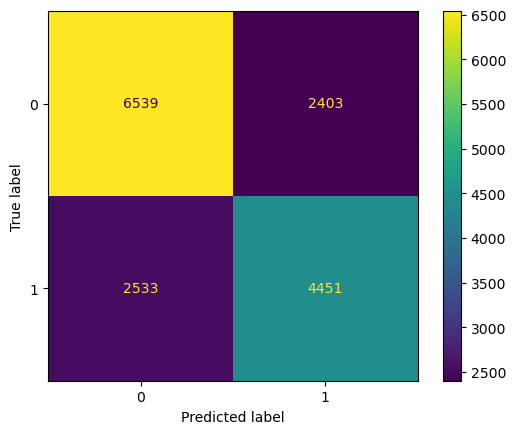

In [27]:
# Generate confusion matrix
conf_matrix_plot(decision_tree, X_test, y_test)

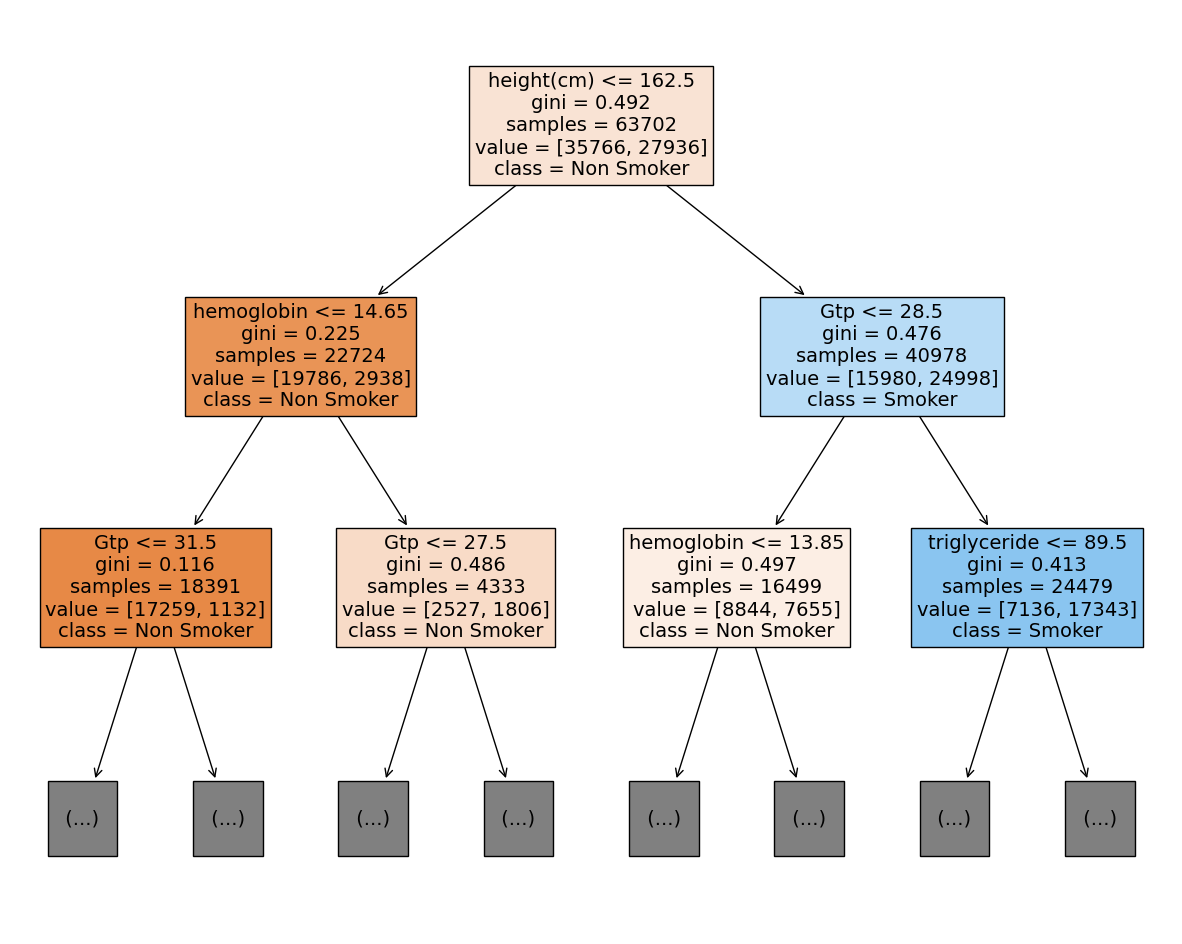

In [30]:
# Plot the tree
plt.figure(figsize=(15,12))
plot_tree(decision_tree, max_depth=2, fontsize=14, feature_names=list(X.columns),
          class_names=['Non Smoker', 'Smoker'], filled=True);
plt.show()

## Tuned Decision Tree (Accuracy: 0.755)

Here we tune the tree. We use two sets of hyperparameters and run a grid search on them. We look at the scores and visualize the tree.

In [31]:
# Assign a dictionary of hyperparameters to search over
tree_para = {
    "max_depth": randint(4, 10),
    "min_samples_leaf": randint(30, 100),
}

In [32]:
# Instantiate the classifier
tuned_decision_tree = DecisionTreeClassifier(random_state = 42)

In [48]:
# Instantiate the RandomizedSearch with Cross Validation
clf = RandomizedSearchCV(tuned_decision_tree,
                         tree_para,
                         scoring=scoring,
                         cv=5,
                         refit='f1',
                         n_jobs=1,
                         verbose=2,
                         n_iter=10,
                         return_train_score=True)

In [49]:
%%time
# Fit the model
clf.fit(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END ...................max_depth=5, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=5, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=4, min_samples_leaf=44; total time=   0.1s
[CV] END ...................max_depth=4, min_samples_leaf=44; total time=   0.1s
[CV] END ...................max_depth=4, min_samples_leaf=44; total time=   0.1s
[CV] END ...................max_depth=4, min_samples_leaf=44; total time=   0.1s
[CV] END ...................max_depth=4, min_samples_leaf=44; total time=   0.1s
[CV] END ...................max_depth=8, min_samples_leaf=93; total time=   0.2s
[CV] END ...................max_depth=8, min_sam

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=42),
                   n_jobs=1,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1680e7d50>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x1680d3010>},
                   refit='f1', return_train_score=True,
                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                   verbose=2)

In [ ]:
# Pickle the model
with open('/content/clf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(clf, to_write)

In [50]:
# Examine the best model from GridSearch
clf.best_estimator_

DecisionTreeClassifier(max_depth=8, min_samples_leaf=93, random_state=42)

In [51]:
print("Best Avg. Validation Score: ", "%.4f" % clf.best_score_)

Best Avg. Validation Score:  0.7433


In [63]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results = cv_results[['param_max_depth', 'param_min_samples_leaf',
                         'mean_test_f1', 'mean_test_recall', 'mean_test_precision',
                         'mean_test_accuracy']]
cv_results.sort_values(by='mean_test_f1', ascending=False).head()

,param_max_depth,param_min_samples_leaf,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
2,8,93,0.743252,0.806271,0.689561,0.755738
8,6,60,0.741294,0.803945,0.687870,0.753980
1,4,44,0.740772,0.826031,0.671856,0.746617
4,4,71,0.740772,0.826031,0.671856,0.746617
5,7,78,0.739659,0.790557,0.695289,0.756052


In [ ]:
# Call the function on our model
result_table = make_results("Tuned Decision Tree", clf)

In [ ]:
result_table.head()

### Visualization

In [ ]:
dtreeviz(boston_tree_pruned, X, y, target_name='MEDV', feature_names=X.columns,
        fontname='DejaVu Sans', scale=1.5,label_fontsize=10, fancy=True)

## Random Forest (Accuracy: 0.770)

In [73]:
%%time

rf = RandomForestClassifier(random_state=0, max_features='sqrt')

cv_params = {"max_depth": randint(6, 12), # default 3
              "min_samples_leaf": randint(60, 150), # default 100
             'min_samples_split': randint(2, 20),
             'n_estimators': randint(100,200)
             }

rf_cv = RandomizedSearchCV(rf, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=2, verbose=2, n_iter=60, return_train_score=True)

rf_cv.fit(X_train, y_train)

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END max_depth=11, min_samples_leaf=135, min_samples_split=3, n_estimators=130; total time=   4.3s
[CV] END max_depth=11, min_samples_leaf=135, min_samples_split=3, n_estimators=130; total time=   4.3s
[CV] END max_depth=11, min_samples_leaf=135, min_samples_split=3, n_estimators=130; total time=   4.3s
[CV] END max_depth=11, min_samples_leaf=135, min_samples_split=3, n_estimators=130; total time=   4.3s
[CV] END max_depth=11, min_samples_leaf=135, min_samples_split=3, n_estimators=130; total time=   4.3s
[CV] END max_depth=9, min_samples_leaf=111, min_samples_split=5, n_estimators=181; total time=   5.6s
[CV] END max_depth=9, min_samples_leaf=111, min_samples_split=5, n_estimators=181; total time=   5.6s
[CV] END max_depth=9, min_samples_leaf=111, min_samples_split=5, n_estimators=181; total time=   5.6s
[CV] END max_depth=9, min_samples_leaf=111, min_samples_split=5, n_estimators=181; total time=   5.6s
[CV] END max_de

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=0),
                   n_iter=60, n_jobs=2,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2859de390>,
                                        'min_samples_leaf': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x2859dfe10>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17710c350>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x17710c1d0>},
                   refit='f1', return_train_score=True,
                   scoring=['accuracy', 'precision', 'recall', 'f1', 'roc_auc'],
                   verbose=2)

In [ ]:
with open('/content/rf_cv_model.pickle', 'wb') as to_write:
    pickle.dump(rf_cv, to_write)

In [74]:
rf_cv.best_params_

{'max_depth': 11,
 'min_samples_leaf': 60,
 'min_samples_split': 11,
 'n_estimators': 172}

In [75]:
rf_cv.best_score_

0.7553896091576386

In [ ]:
rf_cv_results = make_results('Random Forest CV', rf_cv)
rf_cv_results

In [77]:
cv_results = pd.DataFrame(clf.cv_results_)
cv_results = cv_results[['param_max_depth', 'param_min_samples_leaf',
                         'mean_test_f1', 'mean_test_recall', 'mean_test_precision',
                         'mean_test_accuracy']]
cv_results.sort_values(by='mean_test_accuracy', ascending=False).head()

,param_max_depth,param_min_samples_leaf,mean_test_f1,mean_test_recall,mean_test_precision,mean_test_accuracy
3,9,69,0.739413,0.787837,0.696642,0.756507
9,7,62,0.739648,0.790521,0.695348,0.756052
5,7,78,0.739659,0.790557,0.695289,0.756052
7,7,41,0.739469,0.790557,0.695055,0.755816
2,8,93,0.743252,0.806271,0.689561,0.755738


## XGBoost (0.777)

In [ ]:
xgb = XGBClassifier(objective='binary:logistic', random_state=0)

cv_params = {"max_depth": randint(3, 10),
             'min_child_weight': randint(1, 5),
             "learning_rate": uniform(0.03, 0.3),
             "n_estimators": randint(100, 150),
             "colsample_bytree": uniform(0.7, 0.3),
             "gamma": uniform(0, 0.5),
             "subsample": uniform(0.6, 0.4)
             }

xgb_cv = RandomizedSearchCV(xgb, cv_params, scoring=scoring, cv=5, refit='f1', n_jobs=-1, verbose=2, n_iter=20, return_train_score=True)

In [ ]:
%%time
xgb_cv.fit(X_train, y_train)

In [ ]:
# Pickle the model
with open('/content/xgb_cv_model.pickle', 'wb') as to_write:
    pickle.dump(xgb_cv, to_write)

In [ ]:
# Open pickled model
with open('/content/xgb_cv_model.pickle', 'rb') as to_read:
    xgb_cv = pickle.load(to_read)

In [ ]:
print('F1 score XGB CV: ', xgb_cv.best_score_)

In [ ]:
xgb_cv_results = make_results('XGBoost CV', xgb_cv)
xgb_cv_results

In [ ]:
# Generate confusion matrix
conf_matrix_plot(xgb_cv, X_test, y_test)

## Using Optuna (0.778)

In [ ]:
# Defining the objective function
def objective(trial):
    params = {
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 10),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 100),
        "subsample": trial.suggest_float("subsample", 0.5, 1),
        "gamma": trial.suggest_float("gamma", 0, 1),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 0.8),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.3, 0.8),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.3, 0.8),
    }

    model = xgb.XGBClassifier(**params)
    scores = cross_val_score(model, X_train, y_train, cv=5)  # Cross-validation
    accuracy = scores.mean()

    return accuracy

    #ROC_AUC is more useful for imbalanced classes
    '''
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    auc = scores.mean()
    return auc
    '''


In [ ]:
# Run the study
study = optuna.create_study(direction="maximize")  # Maximize accuracy
study.optimize(objective, n_trials=100)  # Run 100 trials

In [ ]:
# Get the best params
best_params = study.best_params
print(best_params)

In [ ]:
best_params = {'learning_rate': 0.09948026949201931, 'max_depth': 9, 'min_child_weight': 48.29001476764355, 'subsample': 0.9811454323867626, 'gamma': 0.2925912079630265, 'colsample_bytree': 0.7327204400110943, 'colsample_bylevel': 0.6042930310459557, 'colsample_bynode': 0.5936489947058167}

In [ ]:
# Use the best params to tune the model
best_model = XGBClassifier(objective='binary:logistic', random_state=0,
                   scoring = scoring, **best_params)

best_model.fit(X_train, y_train)

In [ ]:
scores = cross_val_score(best_model, X_train, y_train, cv=5)  # Cross-validation
accuracy = scores.mean()

In [ ]:
print('Accuracy score XGB Optuna: ', accuracy)

## LightGBM (0.779)

In [78]:
lgb_train = lgb.Dataset(X_train, label=y_train)
lgb_eval = lgb.Dataset(X_test, label=y_test, reference=lgb_train)  # For evaluation during training

In [79]:
param_grid = {
    'objective': ['binary'],
    'learning_rate': [0.01, 0.05, 0.1],
    'num_leaves': [20, 31, 42],
    'feature_fraction': [0.7, 0.8, 0.9],
    'bagging_fraction': [0.6, 0.7, 0.8],
}

In [80]:
clf = lgb.LGBMClassifier()

In [81]:
random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_grid,
                                   n_iter=20,  # Number of random hyperparameter combinations to try
                                   scoring = 'roc_auc',
                                   cv=5)  # Number of cross-validation folds

In [82]:
%%time
random_search.fit(X_train, y_train)

[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] feature_fraction is set=0.9, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info] Number of positive: 22349, number of negative: 28612
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001914 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2480
[LightGBM] [Info] Number of data points in the train set: 50961, number of used features: 32
[LightGBM] [In

RandomizedSearchCV(cv=5, estimator=LGBMClassifier(), n_iter=20,
                   param_distributions={'bagging_fraction': [0.6, 0.7, 0.8],
                                        'feature_fraction': [0.7, 0.8, 0.9],
                                        'learning_rate': [0.01, 0.05, 0.1],
                                        'num_leaves': [20, 31, 42],
                                        'objective': ['binary']},
                   scoring='roc_auc')

In [83]:
best_score = random_search.best_score_
print(f"Best score achieved: {best_score}")

Best score achieved: 0.8604716756461522


In [86]:
cv_results = pd.DataFrame(random_search.cv_results_)
cv_results.sort_values(by='mean_test_score', ascending=False).head()


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_objective,param_num_leaves,param_learning_rate,param_feature_fraction,param_bagging_fraction,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
16,0.550742,0.012561,0.019750,0.000986,binary,31,0.1,0.8,0.8,"{'objective': 'binary', 'num_leaves': 31, 'lea...",0.858630,0.854992,0.864856,0.860176,0.863706,0.860472,0.003555,1
12,0.404659,0.002650,0.018844,0.001205,binary,20,0.1,0.8,0.6,"{'objective': 'binary', 'num_leaves': 20, 'lea...",0.859145,0.854375,0.865066,0.859911,0.862148,0.860129,0.003538,2
18,0.730797,0.006609,0.021949,0.000671,binary,42,0.05,0.7,0.7,"{'objective': 'binary', 'num_leaves': 42, 'lea...",0.857777,0.854215,0.864689,0.859330,0.861695,0.859541,0.003540,3
5,0.716371,0.009667,0.021796,0.000042,binary,42,0.05,0.8,0.7,"{'objective': 'binary', 'num_leaves': 42, 'lea...",0.857819,0.853298,0.863887,0.858614,0.861376,0.858999,0.003566,4
1,0.777505,0.057434,0.022392,0.000886,binary,42,0.05,0.8,0.6,"{'objective': 'binary', 'num_leaves': 42, 'lea...",0.857819,0.853298,0.863887,0.858614,0.861376,0.858999,0.003566,4


In [84]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred.round())
print(f"Accuracy of the best model on the test set: {accuracy}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Accuracy of the best model on the test set: 0.7792917242245385


In [87]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_train)
accuracy = accuracy_score(y_train, y_pred.round())
print(f"Accuracy of the best model on the test set: {accuracy}")

[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
Accuracy of the best model on the test set: 0.7994411478446517


## Explaining the Model

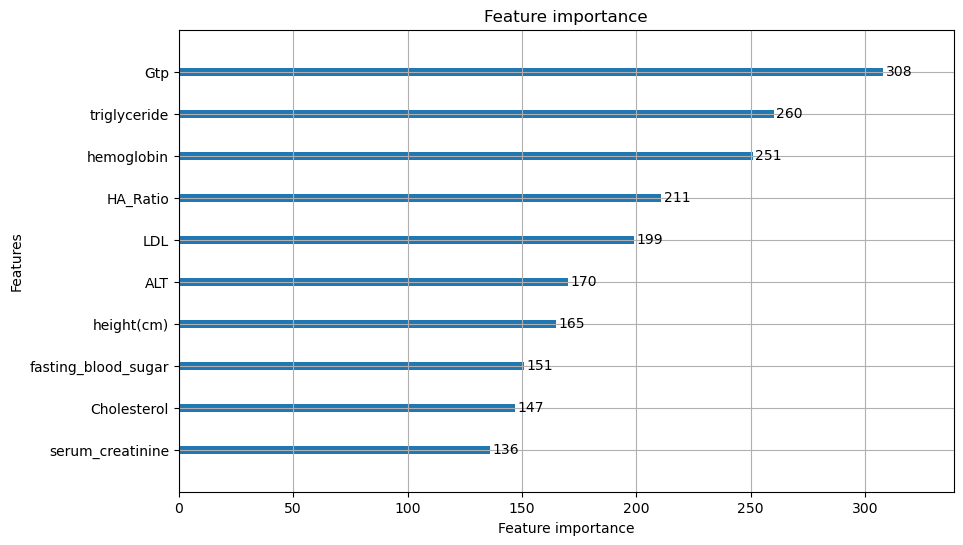

In [89]:
lgb.plot_importance(best_model, importance_type='split', max_num_features=10, figsize=(10, 6))
plt.show()
